In [1]:
from itertools import chain, repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap
import xgboost as xgb
from sklearn.metrics import auc, roc_curve, average_precision_score

from hp_pred.experiments import bootstrap_test, objective_xgboost, precision_event_recall, load_labelized_cases, print_statistics, get_all_stats

optuna.logging.set_verbosity(optuna.logging.WARNING)

/home/aubouinb/Nextcloud/Code/hypotension_pred/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct']
STATIC_FEATURE = ["age", "bmi", "asa"]
HALF_TIME_FILTERING = [60, 3*60, 10*60]

## Load and format data

In [3]:
# import the data frame and add the meta data to the segments
model_filename = 'xgb_30_s_bis.json'
dataset = '30_s_dataset'
data = pd.read_parquet(Path(f'data/datasets/{dataset}/cases/'))

static = pd.read_parquet(f'data/datasets/{dataset}/meta.parquet')

data = data.merge(static, on='caseid')

train = data[data['split'] == "train"]
test = data[data['split'] == "test"]

## Train or load existing model


In [6]:
# control reproducibility
rng_seed = 42


# FEATURE_NAME = (
#     [
#         f"{signal}_ema_{half_time}"
#         for signal in SIGNAL_FEATURE
#         for half_time in HALF_TIME_FILTERING
#     ]
#     + [
#         f"{signal}_std_{half_time}"
#         for signal in SIGNAL_FEATURE
#         for half_time in HALF_TIME_FILTERING
#     ]
#     + STATIC_FEATURE
# )


FEATURE_NAME = (
    [
        f"{signal}_constant_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_slope_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_std_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + STATIC_FEATURE
)
#remove feature with std_60 in the name
FEATURE_NAME = [x for x in FEATURE_NAME if "std_60" not in x]

# create a regressor
train = train.dropna(subset=FEATURE_NAME)
test = test.dropna(subset=FEATURE_NAME)
print(
    f"{len(train):,d} train samples, "
    f"{len(test):,d} test samples, "
    f"{test['label'].mean():.2%} positive rate."
)

# Set model file, create models folder if does not exist.
model_folder = Path("data/models")
if not model_folder.exists():
    model_folder.mkdir()
model_file = model_folder / model_filename


if model_file.exists():
    model = xgb.XGBClassifier()
    model.load_model(model_file)
else:
    number_fold = len(train.cv_split.unique())
    data_train_cv = [train[train.cv_split != f'cv_{i}'] for i in range(number_fold)]
    data_test_cv = [train[train.cv_split == f'cv_{i}'] for i in range(number_fold)]
    # creat an optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective_xgboost(trial, data_train_cv, data_test_cv, FEATURE_NAME),
        n_trials=2,
        show_progress_bar=True,
    )
    # get the best hyperparameters
    best_params = study.best_params

    model = xgb.XGBClassifier(**best_params)
    # refit the model with best parameters
    model.fit(train[FEATURE_NAME], train.label, verbose=1)

    # save the model
    model.save_model(model_file)

408,379 train samples, 173,038 test samples, 6.88% positive rate.


## Evaluation

### Train AUC compute 

Training AUC: 82.68%
Training AP: 30.37%
Training AUPRC: 50.93%


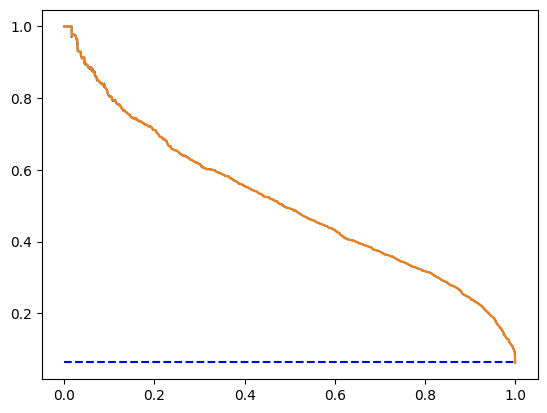

In [7]:
# get training auc


y_pred = model.predict_proba(train[FEATURE_NAME])[:, 1]
y_train = train["label"].values
y_label = train["label_id"].values
fpr, tpr, _ = roc_curve(y_train, y_pred)
auc_train = auc(fpr, tpr)
precision_train, recall_train, _ = precision_event_recall(y_train, y_pred, y_label)
ap_train = average_precision_score(y_train, y_pred)

tpr_train = np.interp(np.linspace(0, 1, 1000), fpr, tpr)
plt.plot(recall_train, precision_train, label="Train")
precision_train = np.interp(np.linspace(0, 1, 1000), recall_train, precision_train)
plt.plot(np.linspace(0, 1, 1000), precision_train, label="Train interp")
plt.plot([0,1], [np.mean(y_train)]*2, 'b--', label="Random")
auprc_train = np.trapz(precision_train, np.linspace(0, 1, 1000))
print(f"Training AUC: {auc_train:.2%}")
print(f"Training AP: {ap_train:.2%}")
print(f"Training AUPRC: {auprc_train:.2%}")

### Model's prediction variance

#### Variance estimation by bootstrapping

In [8]:
y_pred = model.predict_proba(test[FEATURE_NAME])[:, 1]
y_test = test["label"].to_numpy()
y_label_ids = test["label_id"].to_numpy()

df_results, precision_interpolated, thr_interpolated = bootstrap_test(y_test, y_pred, y_label_ids, n_bootstraps=200, rng_seed=rng_seed, strategy="targeted_recall", target=0.241)

result_folder = Path("data/results")
if not result_folder.exists():
    result_folder.exists()
roc_results = result_folder / "xgboost_results.csv"
df_results.to_csv(roc_results, index=False)


 52%|█████▎    | 105/200 [01:00<00:54,  1.74it/s]


KeyboardInterrupt: 

Print main statistics

In [ ]:
print('Stat at fixed recall')
print('--------------------------------------')
print_statistics(df_results)

Stat at fixed recall
--------------------------------------
AUC: 80.1% ± 0.2%
AP: 21.4% ± 0.3%
AUPRC: 28.4% ± 0.6%
Threshold: 0.27 ± 0.00
Recall: 24.1% ± 0.1%
Precision: 34.0% ± 1.2%
Specificity: 96.0% ± 0.2%
NPV: 99.6% ± 0.0%
F1-score: 0.28 ± 0.00


In [ ]:
recall = np.linspace(0, 1, 1000)
list_precision = []
list_recall = []
list_thr = []
for precision, thr in zip(precision_interpolated, thr_interpolated):
    max_precision = np.max(precision[recall > 0.02])
    id_max = int(np.argmin(np.abs(precision - max_precision)))
    list_precision.append(precision[id_max])
    list_recall.append(recall[id_max])
    list_thr.append(thr[id_max])

print("Stats for max precision recall>0.02")
print(f"precision: {np.mean(list_precision):.2%} +/- {np.std(list_precision):.2%}")
print(f"Recall:  {np.mean(list_recall):.2%} +/- {np.std(list_recall):.2%}")
print(f"Threshold: {np.mean(list_thr):.2f} +/- {np.std(list_thr):.2f}")


Stats for max precision recall>0.02
precision: 43.20% +/- 3.19%
Recall:  4.43% +/- 2.17%
Threshold: 0.39 +/- 0.03


### PRC Plot

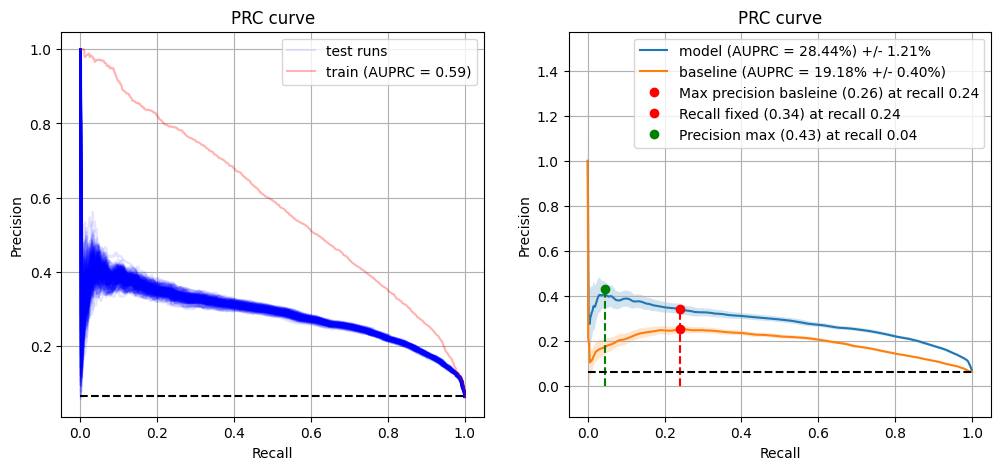

In [ ]:
# plot the ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
recall = np.linspace(0, 1, 1000)
for precision in precision_interpolated:
    plt.plot(recall, precision, "b", alpha=0.1)
plt.plot(recall, precision, "b", alpha=0.1, label="test runs")
plt.plot(recall, precision_train, "r", alpha=0.3, label=f"train (AUPRC = {auprc_train:.2f})")
plt.plot([0, 1], [df_results['precision'].iloc[-1]]*2, "k--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC curve")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
precision_mean, precision_std = df_results.precision.to_numpy(), df_results.precision_std.to_numpy()
auprc, auprc_std = df_results.auprc[0], df_results.auprc_std[0]
plt.fill_between(
    recall, precision_mean - 2 * precision_std, precision_mean + 2 * precision_std, alpha=0.2
)
plt.plot(recall, precision_mean, label=f"model (AUPRC = {auprc:.2%}) +/- {2*auprc_std:.2%}")

# add baseline to the plot
df_baseline = pd.read_csv("data/results/baseline_results.csv")
plt.fill_between(
    df_baseline.recall,
    df_baseline.precision - 2 * df_baseline.precision_std,
    df_baseline.precision + 2 * df_baseline.precision_std,
    alpha=0.2,
)
plt.plot(
    df_baseline.recall.values,
    df_baseline.precision.values,
    label=f"baseline (AUPRC = {df_baseline.auprc[0]:.2%} +/- {df_baseline.auprc_std[0]:.2%})",
)

plt.plot([df_results['recall_threshold'].iloc[-1]]*2, [0, df_results['precision_threshold'].iloc[-1]], 'r--')
plt.plot([df_baseline['recall_threshold'].iloc[-1]], [df_baseline['precision_threshold'].iloc[-1]], 'ro', label=f"Max precision basleine ({df_baseline['precision_threshold'].iloc[-1]:.2f}) at recall {df_baseline['recall_threshold'].iloc[-1]:.2f}")
plt.plot([df_results['recall_threshold'].iloc[-1]], [df_results['precision_threshold'].iloc[-1]], 'ro', label=f"Recall fixed ({df_results['precision_threshold'].iloc[-1]:.2f}) at recall {df_results['recall_threshold'].iloc[-1]:.2f}")

plt.plot([np.mean(list_recall)]*2, [0, np.mean(list_precision)], 'g--')
plt.plot([np.mean(list_recall)], [np.mean(list_precision)], 'go', label=f"Precision max ({np.mean(list_precision):.2f}) at recall {np.mean(list_recall):.2f}")

plt.plot([0, 1], [df_results['precision'].iloc[-1]]*2, "k--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC curve")
plt.legend()
plt.grid()
plt.show()

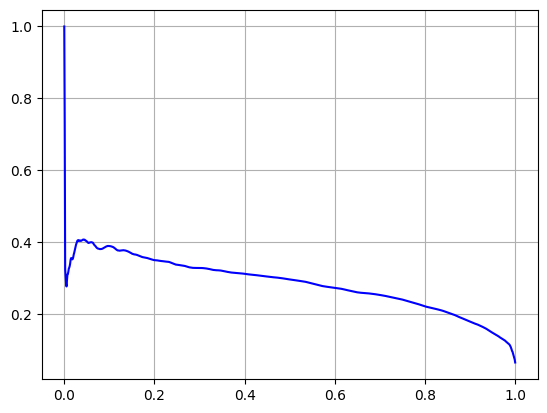

In [ ]:
plt.plot(df_results['recall'], df_results['precision'], 'b')
plt.grid()

## SHAP interpretations

In [ ]:
# use SHAP to explain the model
shap.initjs()
nb_max_feature = 10

model = xgb.Booster()
model.load_model(model_file)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[FEATURE_NAME])
test_data = test[FEATURE_NAME]


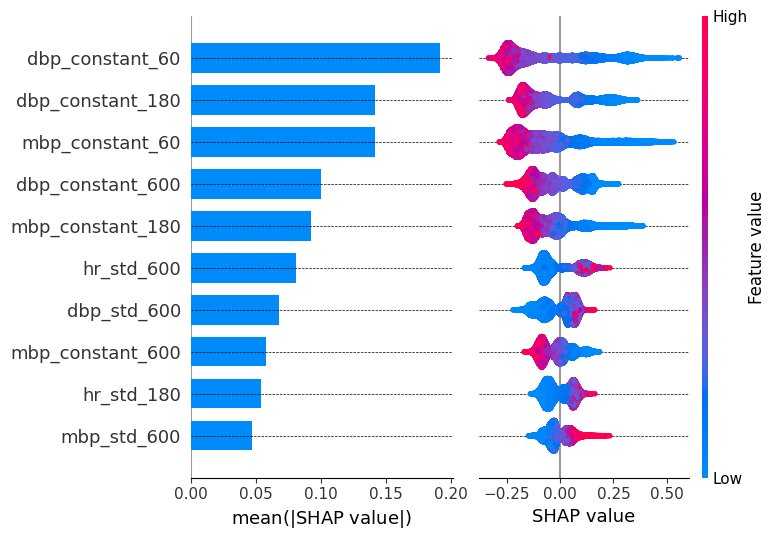

In [ ]:
# plot the SHAP value
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
shap.summary_plot(shap_values, test_data, feature_names=FEATURE_NAME, show=False, plot_type="bar", max_display=nb_max_feature)
plt.xlabel('mean($|$SHAP value$|$)')
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, test_data, feature_names=FEATURE_NAME, show=False, max_display=nb_max_feature)
#remove the y thick label
plt.gca().set_yticklabels([])
plt.xlabel('SHAP value')
plt.tight_layout()
#add horizontal line for each feture
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
plt.savefig('./output/shap_xgboost_manu.pdf', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
# Helper grouping function
revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))

def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

In [ ]:
# Group features
feature_group = {
    'MAP_ema': [name for name in FEATURE_NAME if 'mbp_ema' in name],
    'MAP_std': [name for name in FEATURE_NAME if 'mbp_std' in name],
    'DAP_ema': [name for name in FEATURE_NAME if 'dbp_ema' in name],
    'DAP_std': [name for name in FEATURE_NAME if 'dbp_std' in name],
    'SAP_ema': [name for name in FEATURE_NAME if 'sbp_ema' in name],
    'SAP_std': [name for name in FEATURE_NAME if 'sbp_std' in name],
    'MAC_ema': [name for name in FEATURE_NAME if 'mac_ema' in name],
    'MAC_std': [name for name in FEATURE_NAME if 'mac_std' in name],
    'HR_ema': [name for name in FEATURE_NAME if 'hr_ema' in name],
    'HR_std': [name for name in FEATURE_NAME if 'hr_std' in name],
    'RR_ema': [name for name in FEATURE_NAME if 'rr_ema' in name],
    'RR_std': [name for name in FEATURE_NAME if 'rr_std' in name],
    'SPO2_ema': [name for name in FEATURE_NAME if 'spo2_ema' in name],
    'SPO2_std': [name for name in FEATURE_NAME if 'spo2_std' in name],
    'ETCO2_ema': [name for name in FEATURE_NAME if 'etco2_ema' in name],
    'ETCO2_std': [name for name in FEATURE_NAME if 'etco2_std' in name],
    'PROPO_ema': [name for name in FEATURE_NAME if 'pp_ct_ema' in name],
    'PROPO_std': [name for name in FEATURE_NAME if 'pp_ct_std' in name],
    'AGE': ['age'],
    'BMI': ['bmi'],
    'ASA': ['asa'],
    'PREOP_CR': ['preop_cr'],
    'PREOP_HTN': ['preop_htn'],
    'MAP_constant': [name for name in FEATURE_NAME if 'mbp_constant' in name],
    'MAP_slope': [name for name in FEATURE_NAME if 'mbp_slope' in name],
    'DAP_constant': [name for name in FEATURE_NAME if 'dbp_constant' in name],
    'DAP_slope': [name for name in FEATURE_NAME if 'dbp_slope' in name],
    'SAP_constant': [name for name in FEATURE_NAME if 'sbp_constant' in name],
    'SAP_slope': [name for name in FEATURE_NAME if 'sbp_slope' in name],
    'MAC_constant': [name for name in FEATURE_NAME if 'mac_constant' in name],
    'MAC_slope': [name for name in FEATURE_NAME if 'mac_slope' in name],
    'HR_constant': [name for name in FEATURE_NAME if 'hr_constant' in name],
    'HR_slope': [name for name in FEATURE_NAME if 'hr_slope' in name],
    'RR_constant': [name for name in FEATURE_NAME if 'rr_constant' in name],
    'RR_slope': [name for name in FEATURE_NAME if 'rr_slope' in name],
    'SPO2_constant': [name for name in FEATURE_NAME if 'spo2_constant' in name],
    'SPO2_slope': [name for name in FEATURE_NAME if 'spo2_slope' in name],
    'ETCO2_constant': [name for name in FEATURE_NAME if 'etco2_constant' in name],
    'ETCO2_slope': [name for name in FEATURE_NAME if 'etco2_slope' in name],
    'PROPO_constant': [name for name in FEATURE_NAME if 'pp_ct_constant' in name],
    'PROPO_slope': [name for name in FEATURE_NAME if 'pp_ct_slope' in name],
    'MAP_pred': [name for name in FEATURE_NAME if 'mbp_pred' in name],
    'DAP_pred': [name for name in FEATURE_NAME if 'dbp_pred' in name],
    'SAP_pred': [name for name in FEATURE_NAME if 'sbp_pred' in name],
    'MAC_pred': [name for name in FEATURE_NAME if 'mac_pred' in name],
    'HR_pred': [name for name in FEATURE_NAME if 'hr_pred' in name],
    'RR_pred': [name for name in FEATURE_NAME if 'rr_pred' in name],
    'SPO2_pred': [name for name in FEATURE_NAME if 'spo2_pred' in name],
    'ETCO2_pred': [name for name in FEATURE_NAME if 'etco2_pred' in name],
    'PROPO_pred': [name for name in FEATURE_NAME if 'pp_ct_pred' in name],
}


shap_group = grouped_shap(shap_values, FEATURE_NAME, feature_group)
test_data_group = grouped_shap(test_data, FEATURE_NAME, feature_group)


In [ ]:
# plot the grouped SHAP value
font_size = 16

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
shap.summary_plot(shap_group, test_data_group, feature_names=shap_group.columns, show=False, plot_type="bar", max_display=nb_max_feature)
plt.xlabel('mean($|$SHAP value$|$)', fontsize=font_size)
ax = plt.gca()
ax.tick_params(axis='y', labelsize=font_size)

plt.subplot(1, 2, 2)
shap.summary_plot(shap_group.values, test_data_group, feature_names=shap_group.columns, max_display=nb_max_feature, show=False)
plt.xlabel('SHAP value', fontsize=font_size)
#remove the y thick label
ax = plt.gca()
ax.set_yticklabels([])
for i in range(nb_max_feature):
    plt.axhline(y=i, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('./report/figures/shap_xgboost_group.pdf', bbox_inches='tight', dpi=600)
plt.show()

## exemple of cases


In [ ]:
# plot 3 random cases with the corresponding decision function

np.random.seed(13)
cases = np.random.choice(test['caseid'].unique(), 5, replace=False)
model = xgb.Booster()
model.load_model(model_file)
for case in cases:
    raw_case = load_labelized_cases(dataset_path=Path('data/datasets/base_dataset/'), caseid=case)

    segment_data = test[test['caseid'] == case]

    segment_data = segment_data.dropna(subset=FEATURE_NAME)
    x_test = segment_data[FEATURE_NAME]
    y_pred = model.predict(xgb.DMatrix(x_test))

    plt.figure(figsize=(12, 5))
    plt.fill_between(raw_case.index.seconds /60, np.zeros(len(raw_case.index)), raw_case.label*100, label='label', alpha=0.2)
    # FIXME: raw_case.mbp might be NaN. fillna(0) ?
    plt.plot(raw_case.index.seconds /60, raw_case['mbp'])
    plt.hlines(65, raw_case.index.seconds[0]/60, raw_case.index.seconds[-1]/60, color='r', linestyle='--', label='IOH threshold')

    #plot in red point labeled as IOH
    plt.plot(segment_data[segment_data.label>0].time / np.timedelta64(1, 's') /60,y_pred[segment_data.label>0]*100, 'r.', label='model decision function')
    plt.plot(segment_data[segment_data.label==0].time / np.timedelta64(1, 's') /60,y_pred[segment_data.label==0]*100, 'g.', label='model decision function')


    plt.plot(segment_data.time / np.timedelta64(1, 's') /60,segment_data.time_before_IOH, 'x', label='model decision function')
    label_id = segment_data.label_id.str.split('_').str[0].astype(float)

    plt.plot(segment_data.time / np.timedelta64(1, 's') /60, label_id*100, 'x', label='model decision function')

    plt.xlabel('Time (min)')
    # plt.xlim([100, 120])
    # plt.xlim([235, 245])
    # plt.ylim([0, 100])
    plt.legend()
    plt.title(f'Case {case}')
    plt.grid()
    plt.show()


